# Simplified ikeda check the parsed equations


In [1]:
import sympy as sp
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('equations.dill', mode='rb') as file:
    equations = dill.load(file)

In [3]:
with open('symbols.dill', mode='rb') as file:
    symbols = dill.load(file)

## Proposed Formula of the Bilge Keel Roll Damping

In [4]:
equations.B_n_BK

Eq(B_n_BK, A_BK*x_5*exp(B_B2K*x_3**B_B3K + B_BK))

In [5]:
equations.B_n_BK.free_symbols

{A_BK, B_B2K, B_B3K, B_BK, B_n_BK, x_3, x_5}

In [6]:
equations.A_BK

Eq(A_BK, f_1*f_2*f_3)

In [7]:
equations.f_1

Eq(f_1, -2.5751*x_2 + 3.12907723*(0.353356890459364*x_1 - 1)**2 + 2.632)

In [8]:
equations.f_2

Eq(f_2, 0.00255*x_6**2 + 0.122*x_6 + 0.4794)

In [9]:
equations.f_3

Eq(f_3, 4.3944*x_7**2 - 0.0733*x_7*x_8**2 - 0.01185*x_7 + 0.00189*x_8)

In [10]:
equations._asdict()

OrderedDict([('B_44', Eq(B_44, B_BK + B_E + B_F + B_L + B_W)),
             ('B_F', Eq(B_F, 4*c_f*omega*phi_a*r_f**3*rho*s_f/(3*pi))),
             ('c_f', Eq(c_f, 2.38301080148622*sqrt(phi_a**2*r_f**2/(T*v)))),
             ('r_f', Eq(r_f, (B*C_b + 0.2465*C_b*d - 2*G*O + 0.887)/pi)),
             ('s_f', Eq(s_f, B*C_b + 1.75*L_PP*d)),
             ('x_1', Eq(x_1, B/d)),
             ('x_2', Eq(x_2, C_b)),
             ('x_3', Eq(x_3, C_m)),
             ('x_4', Eq(x_4, G*O/d)),
             ('x_5', Eq(x_5, omega_n)),
             ('B_n_W',
              Eq(B_n_W, A_1*exp(-A_2*log(x_5) - 0.694444444444444*A_3**2)/x_5)),
             ('A_1', Eq(A_1, AA_1*A_13 + A_11*x_4**2 + A_12*x_4)),
             ('A_2',
              Eq(A_2, -1.402*x_4**3 + 7.189*x_4**2 - 10.993*x_4 + 9.45)),
             ('A_3',
              Eq(A_3, AA_3 + A_31*x_4**6 + A_32*x_4**5 + A_33*x_4**4 + A_34*x_4**3 + A_35*x_4**2 + A_36*x**4 + A_37)),
             ('x_6', Eq(x_6, phi_a)),
             ('AA_1', Eq(AA_1, A

In [11]:
equations_ = [equation for equation in equations._asdict().values()]

sp.solve(equations.B_n_BK,
         symbols.B_n_BK,
)

[A_BK*x_5*exp(B_B2K*x_3**B_B3K + B_BK)]

In [12]:
subs = [
    (symbols.A_BK,equations.A_BK.rhs),
    (symbols.f_1,equations.f_1.rhs),
    
]
equations.B_n_BK.subs(subs)

Eq(B_n_BK, f_2*f_3*x_5*(-2.5751*x_2 + 3.12907723*(0.353356890459364*x_1 - 1)**2 + 2.632)*exp(B_B2K*x_3**B_B3K + B_BK))

In [13]:
sp.lambdify(symbols.x_4,equations.B_B3K)

<function _lambdifygenerated(x_4)>

In [14]:
from rolldecayestimators.substitute_dynamic_symbols import lambdify

In [15]:
lambdify(equations.B_B3K.rhs)

<function _lambdifygenerated(x_4)>

In [16]:
lambdify(equations.B_n_BK.rhs)

<function _lambdifygenerated(A_BK, B_B2K, B_B3K, B_BK, x_3, x_5)>

In [17]:
lambda_dict = {}
for name, equation in equations._asdict().items():
    lambda_dict[name] = lambdify(equation.rhs)

In [18]:
from collections import namedtuple
Lambdas = namedtuple('Lambdas', lambda_dict.keys())
lambdas = Lambdas(**lambda_dict)

In [19]:
from inspect import signature

In [20]:
def run(function,inputs):
    s = signature(function)
    input_names = set(s.parameters.keys())   
    return function(**inputs[input_names])

In [21]:
B = 60  # [m]
d = 20  # [m]
Lpp = 300  # [m]
b_BK = 0.03*B
l_BK = 0.3*Lpp
phi_a = 20  # [deg]
w_hat = 1.1
Cb = 0.58
Cm = 0.94

OG_div_d = np.linspace(-1.5,0,8)
OG = OG_div_d*d

inputs = pd.DataFrame()
inputs['OG'] = OG
inputs['OG/d'] = OG/d
inputs['x_1'] = B/d
inputs['x_2'] = Cb
inputs['x_3'] = Cm
inputs['x_4'] = OG/d
inputs['x_5'] = w_hat
inputs['x_6'] = phi_a
inputs['x_7'] = b_BK/B
inputs['x_8'] = l_BK/Lpp

inputs['f_1'] = run(lambdas.f_1, inputs)
inputs['f_2'] = run(lambdas.f_2, inputs)
inputs['f_3'] = run(lambdas.f_3, inputs)

inputs['A_BK'] = run(lambdas.A_BK, inputs)
inputs['B_B2K'] = run(lambdas.B_B2K, inputs)
inputs['B_B3K'] = run(lambdas.B_B3K, inputs)
inputs['B_BK'] = run(lambdas.B_BK, inputs)

inputs['B_n_BK'] = run(lambdas.B_n_BK, inputs)

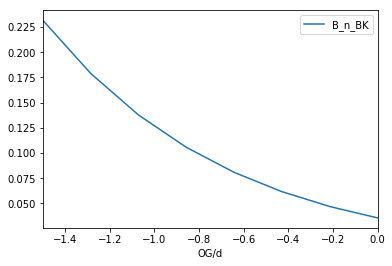

In [26]:
inputs.plot(x='OG/d', y='B_n_BK')

In [22]:
equations.f_1

Eq(f_1, -2.5751*x_2 + 3.12907723*(0.353356890459364*x_1 - 1)**2 + 2.632)

In [23]:
equations.f_2

Eq(f_2, 0.00255*x_6**2 + 0.122*x_6 + 0.4794)

In [24]:
equations.f_3

Eq(f_3, 4.3944*x_7**2 - 0.0733*x_7*x_8**2 - 0.01185*x_7 + 0.00189*x_8)

In [25]:
equations.B_BK

Eq(B_BK, x_4*(0.3*x_1 + 0.00125*x_6**2 - 0.0425*x_6 + 5*x_7 - 0.2*x_8 - 1.86))

In [34]:
equations.B_B2K

Eq(B_B2K, -0.1*x_1 + 1.2*x_2 - 0.0657*x_4**2 + 0.0586*x_4 - 15*x_7 + 1.6164)

In [35]:
equations.B_B3K

Eq(B_B3K, 2.5*x_4 + 15.75)